### SPE for strax
- Estimation of the SPE acceptance using low-intensity LED runs and 'blank' runs that are triggered externally just as for LED runs but with no light emitted;
- Starting from Evan's work (https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:saldanha:xe1t:single_photoelectron_amplitude), I am trying to implement using strax environment;
- Useful for strax: https://github.com/XENONnT/workshop_strax_chicago/tree/master/projects/LED_calibration;
- Strax documentation: https://straxen.readthedocs.io/en/latest/.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
pd.options.display.max_colwidth = 100
import strax
from scipy.optimize import curve_fit
from scipy import stats

import straxen
st = straxen.contexts.strax_workshop_dali()

In [2]:
%run '/home/gvolta/Desktop/SPE/Function.ipynb'

## Datasets

In [3]:
#runs = st.select_runs(available='raw_records', run_mode='LED*', include_tags=['spe_topring', 'spe_topbulk', 'spe_bottom'])
runs = st.select_runs(run_mode='LED*')
st.data_info('raw_records')

Checking data availability: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) - data_orig
8,reduction_level,uint8,Level of data reduction applied (strax.ReductionLevel enum)
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


- Selection of LED data: 180219_1049, 180219_1059;
- Just the first 30 sec for each event.

In [4]:
#data_rr_LED = st.get_array(['180219_1049', '180219_1059'], 'raw_records', seconds_range=(0, 30))
#np.save('data_rr_LED', data_rr_LED)
data_rr_LED = np.load('data_rr_LED.npy')

In [5]:
#data_rr_noise_0 = st.get_array(['180219_0952'], 'raw_records', seconds_range=(0, 30))
#np.save('data_rr_noise_0', data_rr_noise_0)
data_rr_noise_0 = np.load('data_rr_noise_0.npy')

In [6]:
#data_rr_noise_1 = st.get_array(['180219_1030'], 'raw_records', seconds_range=(0, 20))
#np.save('data_rr_noise_1', data_rr_noise_1)
data_rr_noise_1 = np.load('data_rr_noise_1.npy')

In [7]:
def gaus(x, a, mu, sig, const):
    return a*np.exp(-0.5*(x-mu)**2/sig**2)+const

def plot_peak_2(p, **kwargs):
    start = pd.to_datetime(p['time'])
    lenght = len(p['data'])
    x = np.arange(0, lenght, 1)
    plt.plot(x, p['data'], linestyle='steps-mid',
             **kwargs)
    plt.xlabel("Sample")
    plt.ylabel("ADC counts")
    print('Start ' + str(p['channel']) + ': ' + str(pd.to_datetime(start)))

### LED waveform

Start 25: 2018-02-19 10:50:00.000123910
Start 200: 2018-02-19 10:50:00.000123910


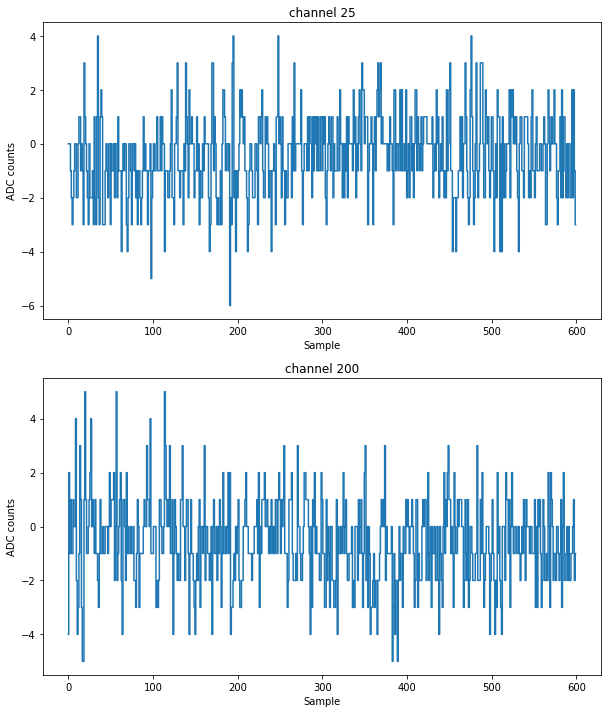

<Figure size 432x288 with 0 Axes>

In [8]:
plt.figure(figsize=(10,12))

plt.subplot(211)
PMT_25_rr_LED = data_rr_LED[data_rr_LED['channel']==25]
plot_peak_2(PMT_25_rr_LED[0], label=pd.to_datetime(PMT_25_rr_LED[0]['time']))
plt.title('channel ' + str(PMT_25_rr_LED['channel'][0]))

plt.subplot(212)
PMT_200_rr_LED = data_rr_LED[data_rr_LED['channel']==200]
plot_peak_2(PMT_200_rr_LED[0], label=pd.to_datetime(PMT_200_rr_LED[0]['time']))
plt.title('channel ' + str(PMT_200_rr_LED['channel'][0]))

plt.show()
plt.tight_layout()

### Noise waveform

Start 25: 2018-02-19 09:52:13.000218790
Start 200: 2018-02-19 10:31:02.000373050


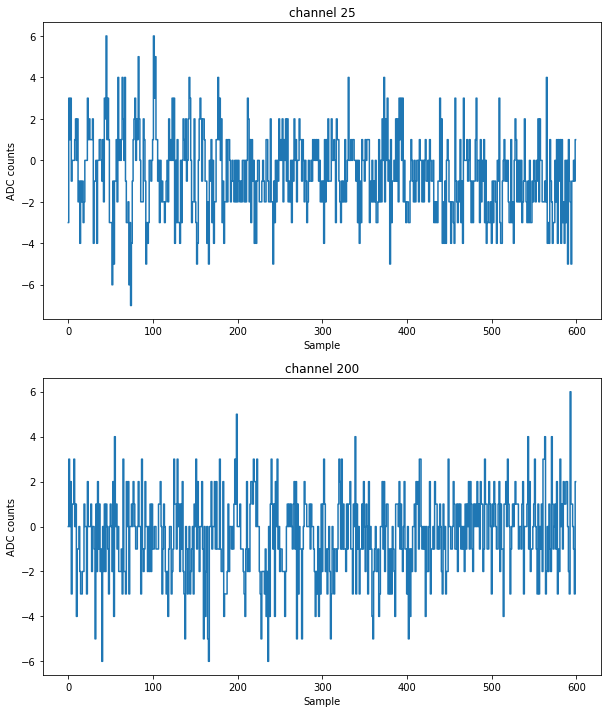

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(10,12))

plt.subplot(211)
PMT_25_rr_noise_0 = data_rr_noise_0[data_rr_noise_0['channel']==25]
plot_peak_2(PMT_25_rr_noise_0[0], label=pd.to_datetime(PMT_25_rr_noise_0[0]['time']))
plt.title('channel ' + str(PMT_25_rr_noise_0['channel'][0]))

plt.subplot(212)
PMT_200_rr_noise_1 = data_rr_noise_1[data_rr_noise_1['channel']==200]
plot_peak_2(PMT_200_rr_noise_1[0], label=pd.to_datetime(PMT_200_rr_noise_1[0]['time']))
plt.title('channel ' + str(PMT_200_rr_noise_1['channel'][0]))

plt.show()
plt.tight_layout()

### Rough SPE Amplitude determination and LED Window Identification
- For each event, and on each channel, we determine the maximum amplitude of the waveform, and then add it to the amplitude spectrum for the corresponding channel;
- Once the rough amplitude range of single photoelectrons is determined, we go back and search for waveforms with maximum values falling in this single pe range. 

In [10]:
info = {'mean': [ ], 'sig': [ ], 'Norm': [ ], 'Const': [ ], 'pmt': [ ]}
d2 = pd.DataFrame({'channel': [ ], 'idx_LED': [ ]}) 
n_channel_s = np.arange(0, 249, 1)
pmts_rejected = [ ]
x = np.arange(0,600,1)

for n_channel in tqdm(n_channel_s):
    #if n_channel in pmts_rejected:
    #     continue   
    wf_tmp = data_rr_LED[data_rr_LED['channel'] == n_channel]
    area_wf = [ ]
    amp_wf = [ ]
    idx_amp_wf = [ ]
    idx_LED = [ ]
    for wf_ in wf_tmp:
        amp_wf.append(np.max(wf_['data']))
        #area_wf.append(wf_['area'])
        #print(np.max(wf_['data']), wf_['area'])
        idx_amp_wf.append(np.argmax(wf_['data']))
    area_wf = np.array(area_wf)
    amp_wf = np.array(amp_wf)
    idx_amp_wf = np.array(idx_amp_wf)
    
    #plt.figure(figsize=(10,6))
    
    #plt.subplot(121)
    #hist, xbins, _ = plt.hist(amp_wf, bins=100, range=(0,200))
    hist, xbins = np.histogram(amp_wf, bins=100, range=(0,200))
    xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])
    
    mask = (xbins_center > 30) & (xbins_center < 200)
    popt, pcov = curve_fit(gaus, xbins_center[mask], hist[mask], p0=[10, 60, 20, 0], maxfev=int(1e6))
    #plt.plot(x, gaus(x, *popt), 'r-', label='Mean: %.1f\nStd: %.1f' %(popt[1], popt[2]))
    
    #plt.title('Channel %d' %n_channel)
    #plt.xlabel('amp (ADC counts)')
    #plt.xlim(0, 200)
    #plt.yscale('log')
    #plt.legend(loc='best')
    
    #plt.subplot(122)
    #hist, xbins, _ = plt.hist(amp_wf, bins=100, range=(0,200))
    #plt.xlabel('Area')
    #plt.yscale('log')
    #plt.legend(loc='best')
    
    #plt.show()
        
    N, mean, sig, c = popt[0], popt[1], popt[2], popt[3]
    #print(mean, sig)
    info['mean'].append(popt[1])
    info['sig'].append(popt[2])
    info['Norm'].append(popt[0])
    info['Const'].append(popt[3])
    info['pmt'].append(n_channel)
    
    d1 = pd.DataFrame({'channel': [ ], 'idx_LED': [ ]})
    mask = (amp_wf < mean + sig) & (amp_wf > mean - sig)
    idx_LED = idx_amp_wf[mask]
    if len(idx_LED)==0:
        d1['channel'] = n_channel
        d1['idx_LED'] = np.nan
    else:
        d1['idx_LED'] = idx_LED
        d1['channel'] = np.ones_like(idx_LED) * n_channel
    d2 = d2.append(d1, ignore_index=True)
    del d1, amp_wf, idx_amp_wf, idx_LED, area_wf

  8%|▊         | 20/249 [00:06<01:13,  3.14it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 66%|██████▌   | 164/249 [00:51<00:25,  3.38it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 249/249 [01:25<00:00,  3.43it/s]


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

mean:  169.7395714258345 	 standard deviation:  74.15394462294016


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


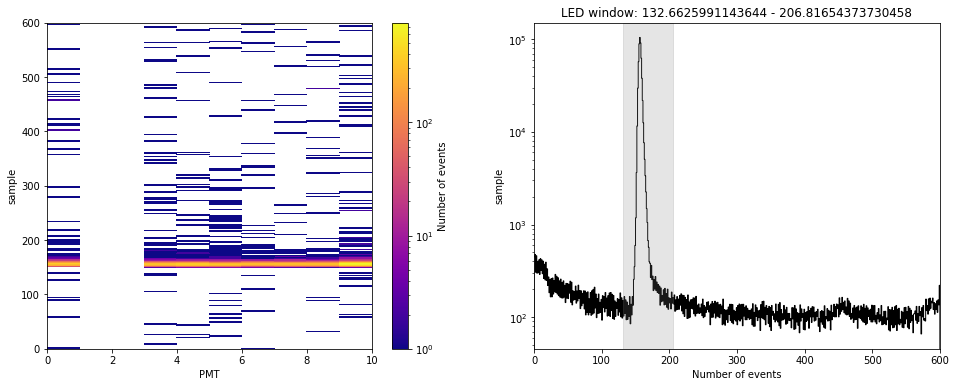

<Figure size 432x288 with 0 Axes>

In [11]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
hist2d, xbins, ybins, _ = plt.hist2d(x = d2['channel'], y = d2['idx_LED'], bins=(10,600), range=((0,10),(0,600)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('PMT')
plt.ylabel('sample')

plt.subplot(122)
y_hist, y_bins, _ = plt.hist(d2['idx_LED'], bins=600, range=(0,600), histtype='step', color='black')
plt.yscale('log')
plt.xlim(0,600)
mean = d2['idx_LED'].mean()
std = d2['idx_LED'].std()
window = [int(mean-0.5*std),int(mean+0.5*std)]
print('mean: ',mean,'\t standard deviation: ', std)
plt.axvspan(*window, color='grey', alpha=0.2)
plt.title('LED window: '+str(mean-0.5*std)+' - '+str(mean+0.5*std))
plt.xlabel('Number of events')
plt.ylabel('sample')

plt.show()
plt.tight_layout()

### Noise Matching
- We would like to try and determine the single photoelectron spectrum down to as low amplitude values as possible, and so we will attempt to subtract away the noise contribution;
- We will do this noise subtraction by taking residual between the LED and noise runs for each configuration. Since the noise run uses the same trigger logic, etc. as the LED run, the amplitude spectrum in the LED window determined above should represent the amplitude spectrum of the noise.

In [12]:
df_LED = pd.DataFrame({'Channel': [ ], 'Amplitude': [ ], 'Time': [ ], 'Area': [ ]})
df_noise = pd.DataFrame({'Channel': [ ], 'Amplitude': [ ], 'Time': [ ], 'Area': [ ]}) 
n_channel_s = np.arange(0, 249, 1)
pmts_rejected = [ ]
x = np.arange(0,600,1)

for n_channel in tqdm(n_channel_s):
    #if n_channel in pmts_rejected:
    #     continue   
    LED_tmp = data_rr_LED[data_rr_LED['channel'] == n_channel]
    noise_tmp = data_rr_noise_0[data_rr_noise_0['channel'] == n_channel]
    
    d1_LED = pd.DataFrame({'Channel': [ ], 'Amplitude': [ ], 'Time': [ ], 'Area': [ ]})
    d1_noise = pd.DataFrame({'Channel': [ ], 'Amplitude': [ ], 'Time': [ ], 'Area': [ ]})
    
    amp_LED = [ ]
    area_LED = [ ]
    time_amp_LED = [ ]
    
    amp_noise = [ ]
    area_noise = [ ]
    time_amp_noise = [ ]
    
    for LED_ in LED_tmp:
        amp_LED.append(np.max(LED_['data'][window[0]:window[1]]))
        area_LED.append(np.sum(LED_['data'][window[0]:window[1]]))
        #print(np.sum(LED_['data'][window[0]:window[1]]))
        time_amp_LED.append(np.argmax(LED_['data'][window[0]:window[1]]))
    for noise_ in noise_tmp:
        amp_noise.append(np.max(noise_['data'][window[0]:window[1]]))
        area_noise.append(np.sum(noise_['data'][window[0]:window[1]]))
        time_amp_noise.append(np.argmax(noise_['data'][window[0]:window[1]]))
        
    d1_LED['Channel'] = np.ones_like(amp_LED) * n_channel
    d1_noise['Channel'] = np.ones_like(amp_noise) * n_channel
    
    d1_LED['Amplitude'] = np.array(amp_LED)
    d1_noise['Amplitude'] = np.array(amp_noise)
    
    d1_LED['Time'] = np.array(time_amp_LED)
    d1_noise['Time'] = np.array(time_amp_noise)
        
    d1_LED['Area'] = np.array(area_LED)
    d1_noise['Area'] = np.array(area_noise)

    df_LED = df_LED.append(d1_LED, ignore_index=True)
    df_noise = df_noise.append(d1_noise, ignore_index=True)    
          
    del d1_LED, d1_noise, amp_LED, amp_noise, time_amp_LED, time_amp_noise, area_LED, area_noise, LED_tmp, noise_tmp

100%|██████████| 249/249 [03:39<00:00,  1.23s/it]


100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


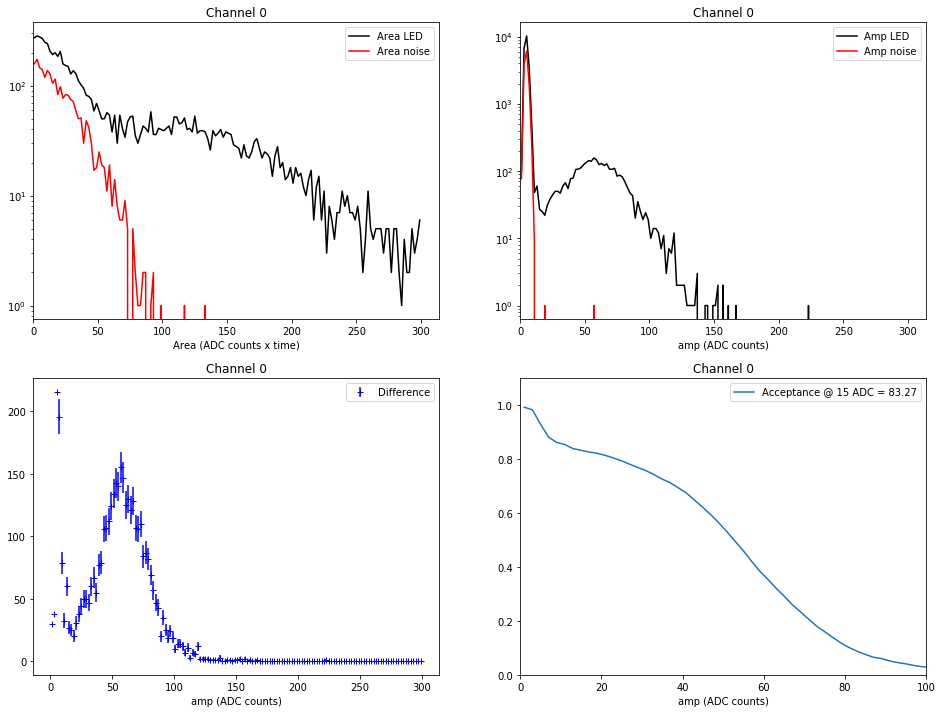

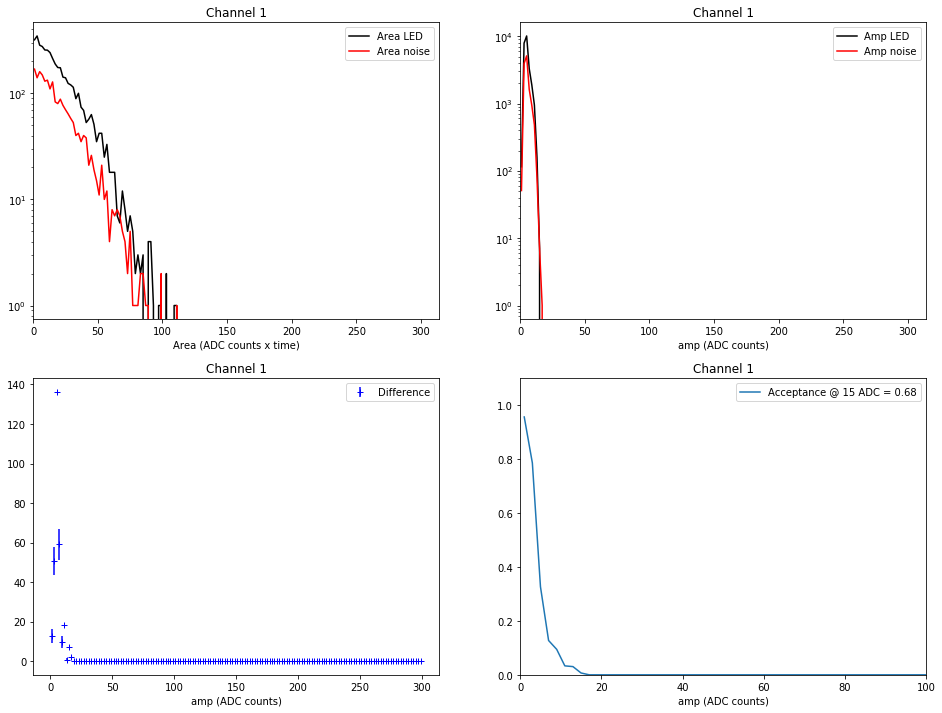

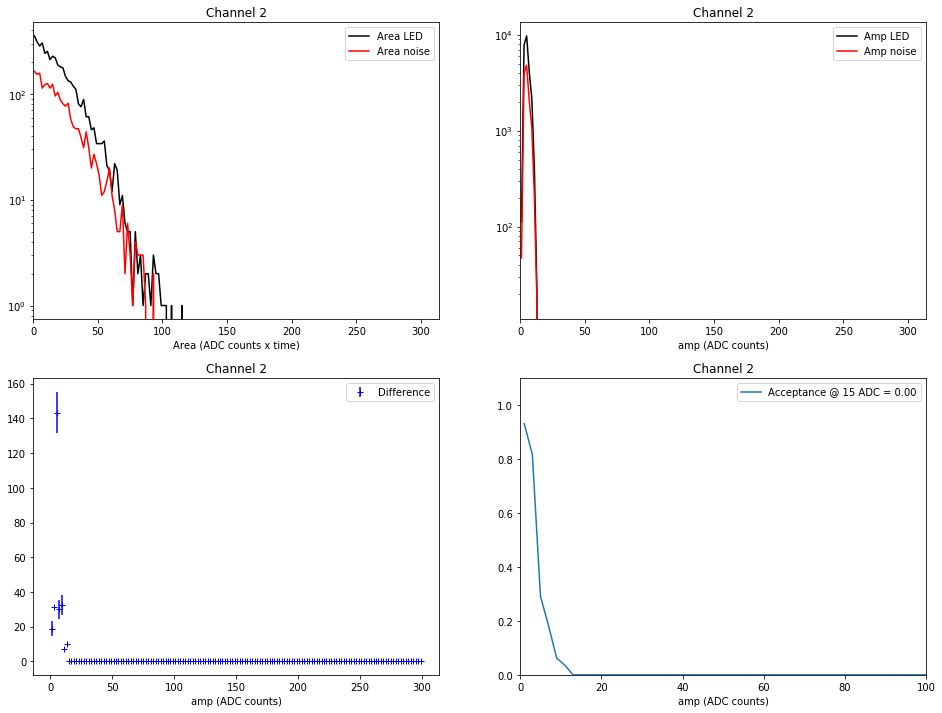

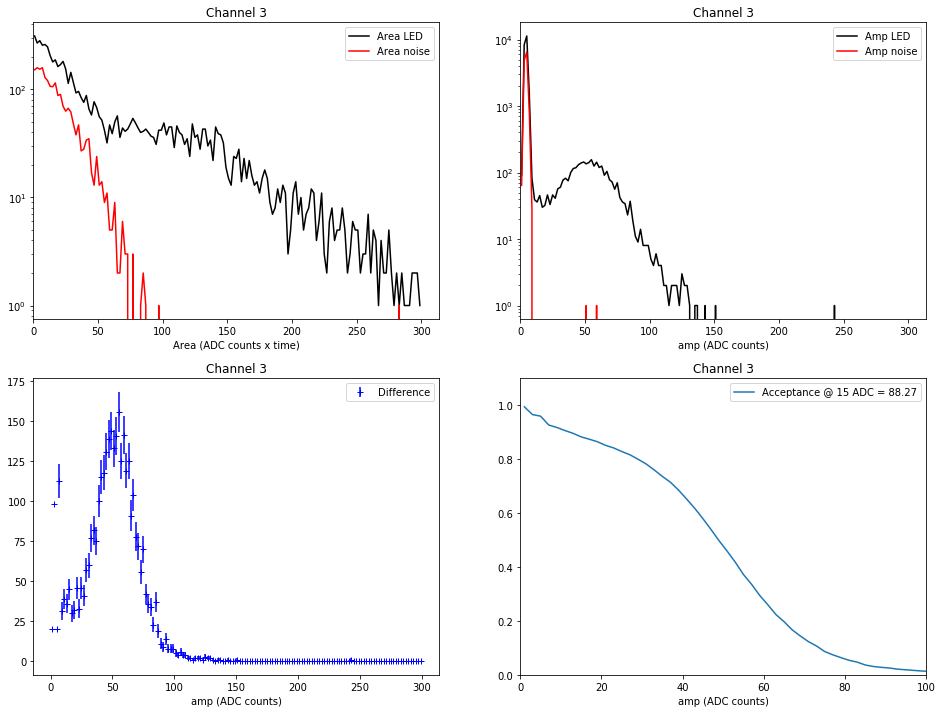

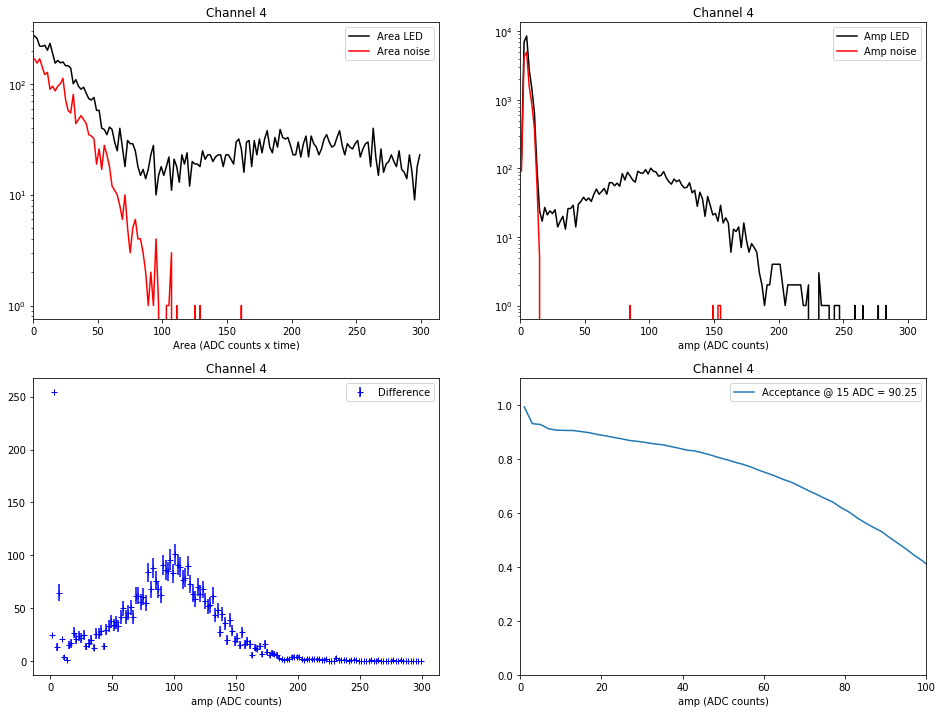

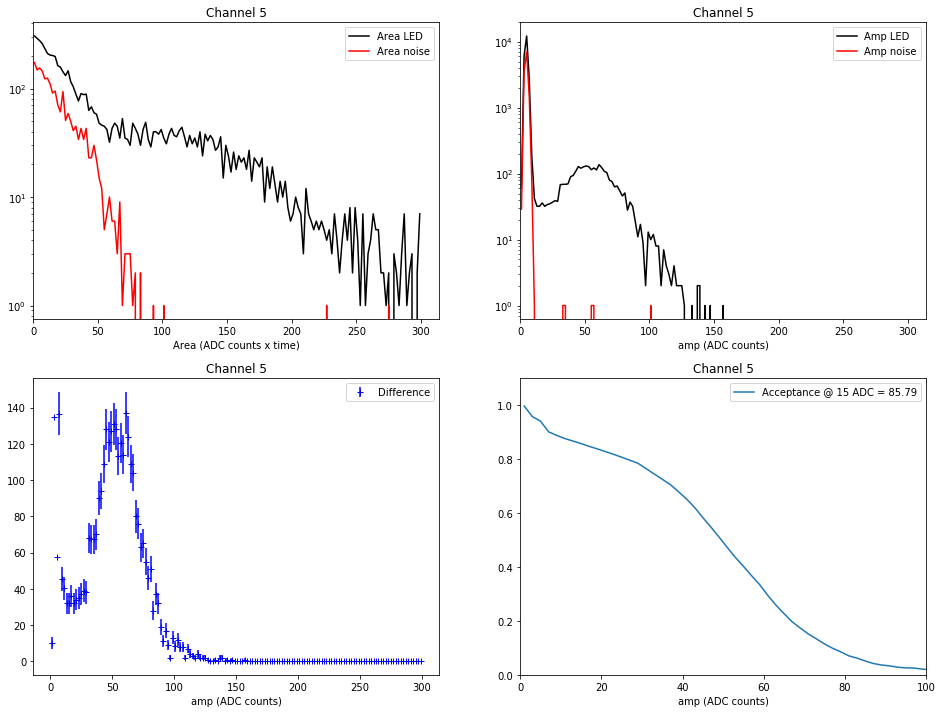

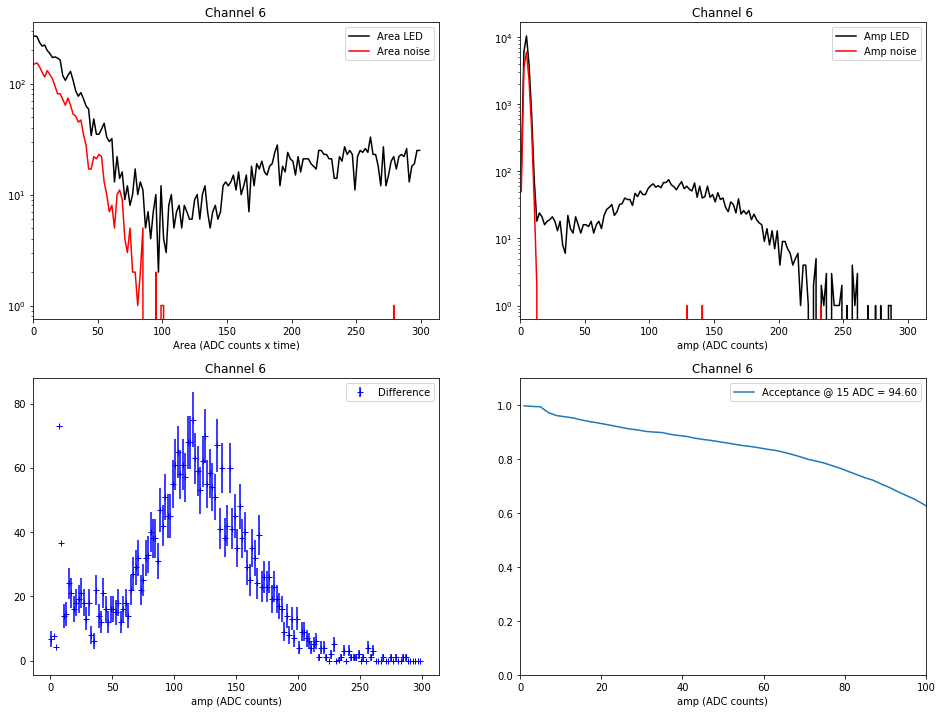

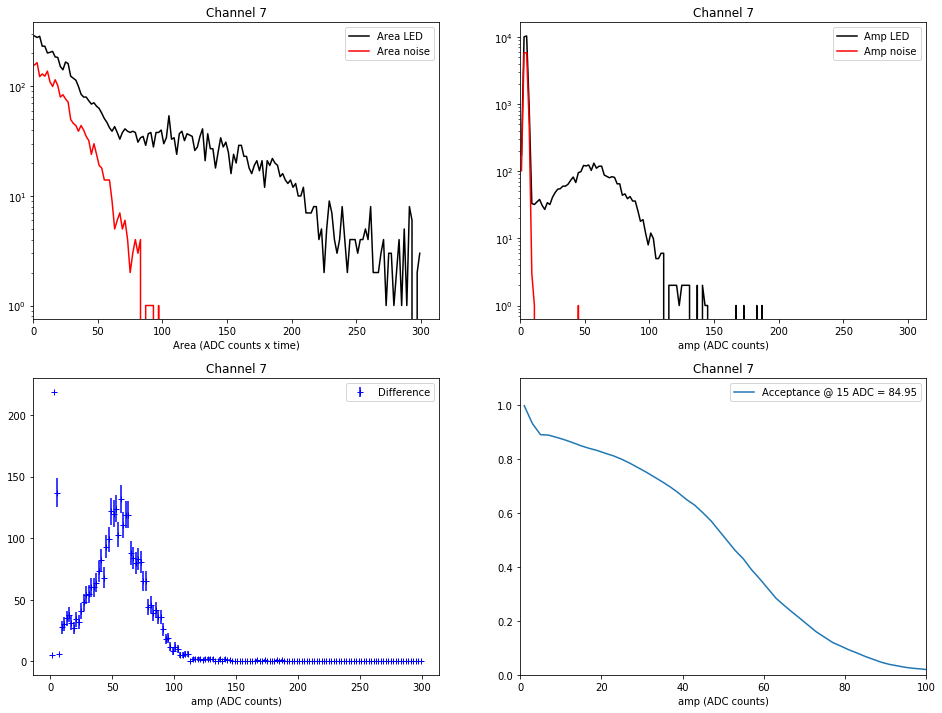

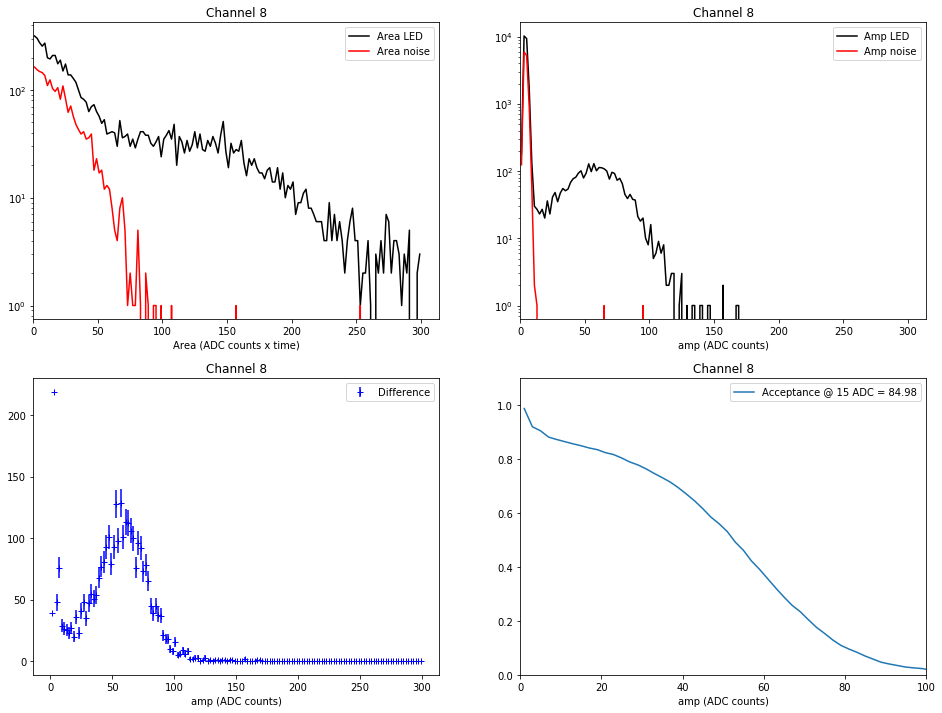

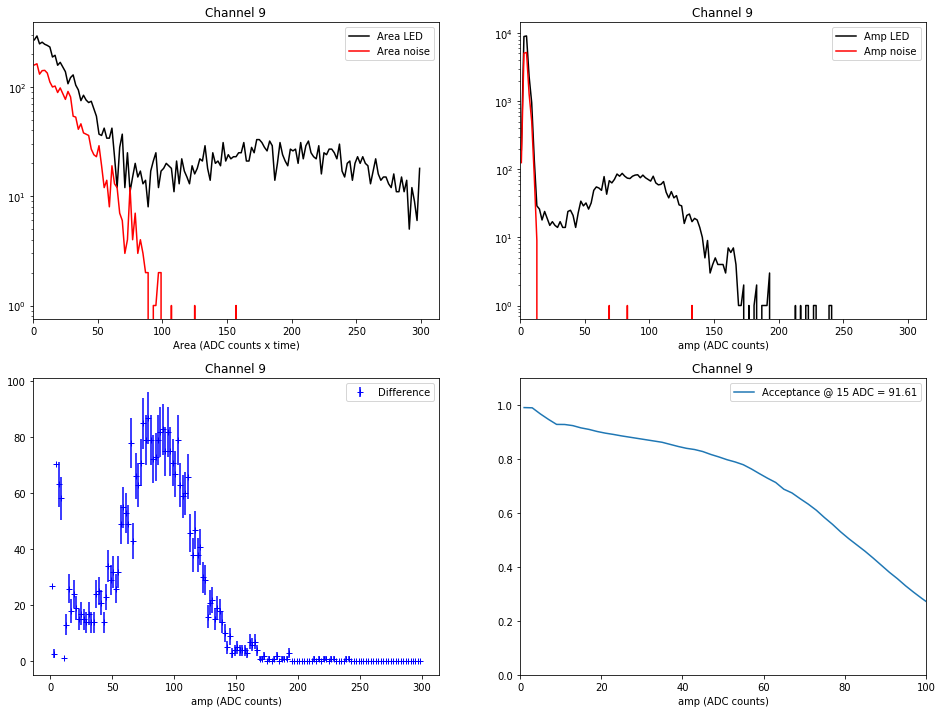

In [13]:
n_channel_s = np.arange(0, 10, 1)

for n_channel in tqdm(n_channel_s):
    df_LED_tmp = df_LED[df_LED['Channel'] == n_channel]
    df_noise_tmp = df_noise[df_noise['Channel'] == n_channel]

    fig = plt.figure(figsize=(16,12))

    LED_amp_spectrum, bins_amp_1 = np.histogram(df_LED_tmp['Amplitude'], bins=150, range=(0,300))
    noise_amp_spectrum, bins_amp_2 = np.histogram(df_noise_tmp['Amplitude'], bins=150, range=(0,300))
    
    LED_area_spectrum, bins_area_1 = np.histogram(df_LED_tmp['Area'], bins=150, range=(0,300))
    noise_area_spectrum, bins_area_2 = np.histogram(df_noise_tmp['Area'], bins=150, range=(0,300))
    
    plt.subplot(221)
    #plt.errorbar(x = bins_1[:len(bins_1)-1], y = LED_spectrum, yerr = np.sqrt(LED_spectrum), fmt='k+', label='LED')
    #plt.errorbar(x = bins_2[:len(bins_2)-1],  y = noise_spectrum_2, yerr = np.sqrt(noise_spectrum_2), fmt='r+', label='noise')
    #plt.vlines(x=ADC_correction, ymin=0, ymax=1e4, colors='k', linestyles='dashed')
    #plt.xlabel('amp (ADC counts)')
    #plt.title('Channel %d - ZOOM' %n_channel)
    #plt.yscale('log')
    #plt.legend(loc='best')
    #plt.xlim(0,50)
    plt.plot([(bins_area_1[i]+bins_amp_1[i+1])*0.5 for i in range(len(bins_area_1)-1)], LED_area_spectrum, color='k', label='Area LED')
    plt.plot([(bins_area_1[i]+bins_area_1[i+1])*0.5 for i in range(len(bins_area_1)-1)], noise_area_spectrum, color='r', label='Area noise')
    plt.xlabel('Area (ADC counts x time)')
    plt.title('Channel %d' %n_channel)
    plt.yscale('log')
    plt.legend(loc='best')
    plt.xlim(0)
    
    plt.subplot(222)
    #plt.hist(df_LED_tmp['Amplitude'], bins=100, range=(0,200), label='LED')
    #plt.hist(df_noise_tmp['Amplitude'], bins=100, range=(0,200), label='noise')
    plt.plot([(bins_amp_1[i]+bins_amp_1[i+1])*0.5 for i in range(len(bins_amp_1)-1)], LED_amp_spectrum, color='k', label='Amp LED')
    plt.plot([(bins_amp_2[i]+bins_amp_2[i+1])*0.5 for i in range(len(bins_amp_2)-1)], noise_amp_spectrum, color='r', label='Amp noise')
    plt.xlabel('amp (ADC counts)')
    plt.title('Channel %d' %n_channel)
    plt.yscale('log')
    plt.legend(loc='best')
    plt.xlim(0)
    
    ADC_correction = 7
    tmp_1 = df_LED_tmp[df_LED_tmp['Amplitude'] < ADC_correction]
    tmp_2 = df_noise_tmp[df_noise_tmp['Amplitude'] < ADC_correction]
    scaling_coeff = tmp_1['Amplitude'].sum()/tmp_2['Amplitude'].sum()
    noise_amp_spectrum_2 = noise_amp_spectrum*scaling_coeff

    plt.subplot(223)
    #hist_LED, xbins_LED = np.histogram(d1_LED['Amplitude'], bins=50, range=(0,50))
    #hist_noise, xbins_noise = np.histogram(d2_noise, bins=50, range=(0,50))
    x_center = [(bins_amp_1[i]+bins_amp_1[i+1])*0.5 for i in range(len(bins_amp_1)-1)]
    diff = abs(LED_amp_spectrum - noise_amp_spectrum_2)
    sigma_diff = np.sqrt(LED_amp_spectrum - noise_amp_spectrum_2)
    plt.errorbar(x = x_center, y=diff, yerr = sigma_diff, fmt='b+', label='Difference')
    #hist_diff, xbins_diff, _ = plt.hist(diff, bins=50, range=(0,50), label='Difference', histtype='step')
    plt.xlabel('amp (ADC counts)')
    plt.title('Channel %d' %n_channel)
    plt.legend(loc='best')
    
    
    plt.subplot(224)
    acc_15ADC = [ ]
    res =  1. - np.cumsum(diff)/np.sum(diff)
    pos_15ADC = x_center.index(15)
    acc = res[pos_15ADC]*100
    acc_15ADC.append(acc)
    plt.plot(x_center, res, label='Acceptance @ 15 ADC = %.2f'%(acc))
    plt.title('Acceptance')
    plt.ylim(0,1.1)
    plt.xlim(0, 100)
    plt.xlabel('amp (ADC counts)')
    plt.title('Channel %d' %n_channel)
    plt.legend(loc='best')
       
    #plt.show()
    #plt.tight_layout()
    #plt.close()
    
    del df_LED_tmp, df_noise_tmp, tmp_1, tmp_2, x_center, diff, sigma_diff, res, pos_15ADC

In [14]:
n_channel_s = np.arange(0, 249, 1)
acc_15ADC = [ ]

for n_channel in tqdm(n_channel_s):
    df_LED_tmp = df_LED[df_LED['Channel'] == n_channel]
    df_noise_tmp = df_noise[df_noise['Channel'] == n_channel]

    fig = plt.figure(figsize=(16,12))

    LED_amp_spectrum, bins_amp_1 = np.histogram(df_LED_tmp['Amplitude'], bins=150, range=(0,300))
    noise_amp_spectrum, bins_amp_2 = np.histogram(df_noise_tmp['Amplitude'], bins=150, range=(0,300))
    
    LED_area_spectrum, bins_area_1 = np.histogram(df_LED_tmp['Area'], bins=150, range=(0,300))
    noise_area_spectrum, bins_area_2 = np.histogram(df_noise_tmp['Area'], bins=150, range=(0,300))
    
    #plt.subplot(221)
    #plt.errorbar(x = bins_1[:len(bins_1)-1], y = LED_spectrum, yerr = np.sqrt(LED_spectrum), fmt='k+', label='LED')
    #plt.errorbar(x = bins_2[:len(bins_2)-1],  y = noise_spectrum_2, yerr = np.sqrt(noise_spectrum_2), fmt='r+', label='noise')
    #plt.vlines(x=ADC_correction, ymin=0, ymax=1e4, colors='k', linestyles='dashed')
    #plt.xlabel('amp (ADC counts)')
    #plt.title('Channel %d - ZOOM' %n_channel)
    #plt.yscale('log')
    #plt.legend(loc='best')
    #plt.xlim(0,50)
    #plt.plot([(bins_area_1[i]+bins_amp_1[i+1])*0.5 for i in range(len(bins_area_1)-1)], LED_area_spectrum, color='k', label='Area LED')
    #plt.plot([(bins_area_1[i]+bins_area_1[i+1])*0.5 for i in range(len(bins_area_1)-1)], noise_area_spectrum, color='r', label='Area noise')
    #plt.xlabel('Area (ADC counts x time)')
    #plt.title('Channel %d' %n_channel)
    #plt.yscale('log')
    #plt.legend(loc='best')
    #plt.xlim(0)
    
    #plt.subplot(222)
    #plt.hist(df_LED_tmp['Amplitude'], bins=100, range=(0,200), label='LED')
    #plt.hist(df_noise_tmp['Amplitude'], bins=100, range=(0,200), label='noise')
    #plt.plot([(bins_amp_1[i]+bins_amp_1[i+1])*0.5 for i in range(len(bins_amp_1)-1)], LED_amp_spectrum, color='k', label='Amp LED')
    #plt.plot([(bins_amp_2[i]+bins_amp_2[i+1])*0.5 for i in range(len(bins_amp_2)-1)], noise_amp_spectrum, color='r', label='Amp noise')
    #plt.xlabel('amp (ADC counts)')
    #plt.title('Channel %d' %n_channel)
    #plt.yscale('log')
    #plt.legend(loc='best')
    #plt.xlim(0)
    
    ADC_correction = 7
    tmp_1 = df_LED_tmp[df_LED_tmp['Amplitude'] < ADC_correction]
    tmp_2 = df_noise_tmp[df_noise_tmp['Amplitude'] < ADC_correction]
    scaling_coeff = tmp_1['Amplitude'].sum()/tmp_2['Amplitude'].sum()
    noise_amp_spectrum_2 = noise_amp_spectrum*scaling_coeff

    #plt.subplot(223)
    #hist_LED, xbins_LED = np.histogram(d1_LED['Amplitude'], bins=50, range=(0,50))
    #hist_noise, xbins_noise = np.histogram(d2_noise, bins=50, range=(0,50))
    x_center = [(bins_amp_1[i]+bins_amp_1[i+1])*0.5 for i in range(len(bins_amp_1)-1)]
    diff = abs(LED_amp_spectrum - noise_amp_spectrum_2)
    sigma_diff = np.sqrt(LED_amp_spectrum - noise_amp_spectrum_2)
    #plt.errorbar(x = x_center, y=diff, yerr = sigma_diff, fmt='b+', label='Difference')
    #hist_diff, xbins_diff, _ = plt.hist(diff, bins=50, range=(0,50), label='Difference', histtype='step')
    #plt.xlabel('amp (ADC counts)')
    #plt.title('Channel %d' %n_channel)
    #plt.legend(loc='best')
    
    
    #plt.subplot(224)
    res =  1. - np.cumsum(diff)/np.sum(diff)
    pos_15ADC = x_center.index(15)
    acc = res[pos_15ADC]*100
    acc_15ADC.append(acc)
    #plt.plot(x_center, res, label='Acceptance @ 15 ADC = %.2f'%(acc))
    #plt.title('Acceptance')
    #plt.ylim(0,1.1)
    #plt.xlim(0, 100)
    #plt.xlabel('amp (ADC counts)')
    #plt.title('Channel %d' %n_channel)
    #plt.legend(loc='best')
       
    #plt.show()
    #plt.tight_layout()
    #plt.close()
    
    del df_LED_tmp, df_noise_tmp, tmp_1, tmp_2, x_center, diff, sigma_diff, res, pos_15ADC

100%|██████████| 249/249 [00:04<00:00, 61.06it/s]


<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

In [15]:
acc_15ADC

[83.26912437027676,
 0.6751441535198244,
 0.0,
 88.26721471758326,
 90.25158830215632,
 85.78658349712461,
 94.59996362103263,
 84.95424163578875,
 84.98306837979963,
 91.6082058341658,
 79.40331292580629,
 93.65621896257001,
 0.0,
 82.96275118780324,
 92.30719468656248,
 92.43633379098631,
 83.23040861375128,
 77.80086148279963,
 82.65518468349345,
 85.02621636646742,
 84.06621319507205,
 72.4250900394848,
 87.87883451382082,
 84.3103659775856,
 92.36559534114681,
 87.10853275065308,
 0.0,
 26.98079619895988,
 82.30613334626551,
 73.8133303021957,
 62.44142644193572,
 35.337983964712485,
 92.41897415143127,
 85.53587292297709,
 0.0,
 95.30751594815482,
 86.67230742676237,
 84.21056794785821,
 94.42310498443938,
 96.14006077972391,
 87.8220968042658,
 91.63047427093946,
 78.23022675805521,
 93.8452353948263,
 88.33776157259149,
 92.03538563589558,
 75.67143363219245,
 90.79549484684067,
 88.55831434226221,
 87.38768383460682,
 87.94172301815176,
 71.84573894204567,
 83.37176340213274,
